# 방 이미지 분류

In [1]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
device = 'mps'

# Data 확인

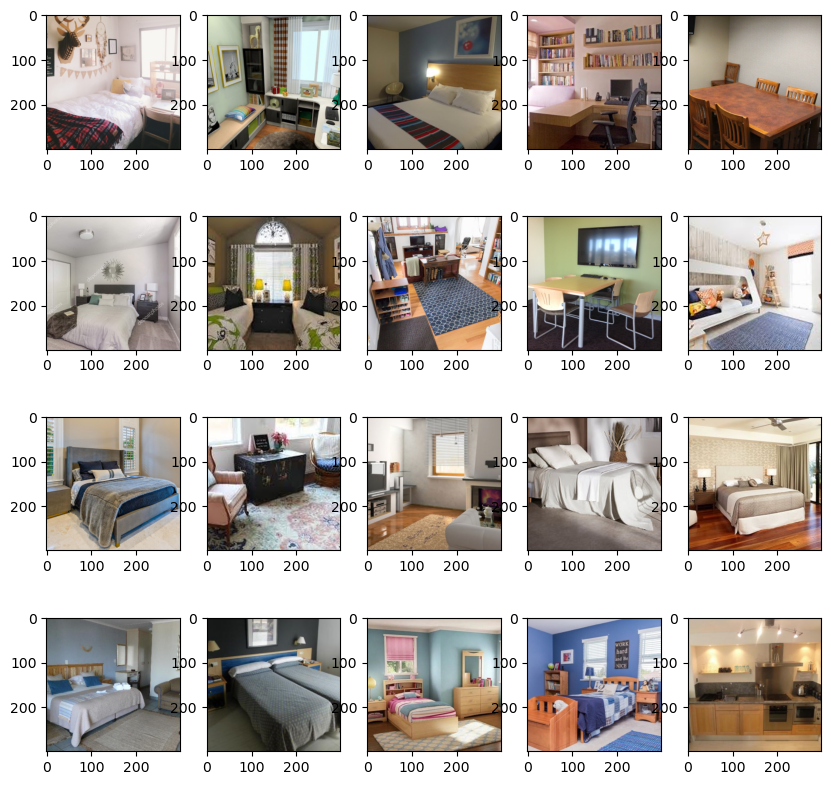

In [5]:
train_clean_img_list = os.listdir('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/train/clean')

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    root = os.path.join('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/train/clean', train_clean_img_list[i])
    img = Image.open(root)
    plt.imshow(img)

# Custom Dataset

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(len(classes)):
            root_dir = os.path.join(root, classes[i])
            img_list = os.listdir(root_dir)
            for img in img_list:
                self.data.append((os.path.join(root_dir, img), i)) # (img 경로, class)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx][0], self.data[idx][1]
        img = Image.open(img)
        img = self.transforms(img)

        return img, label

In [14]:
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])

classes = ['clean', 'messy']

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/val', classes, transforms)

In [15]:
print(len(train_dataset))

192


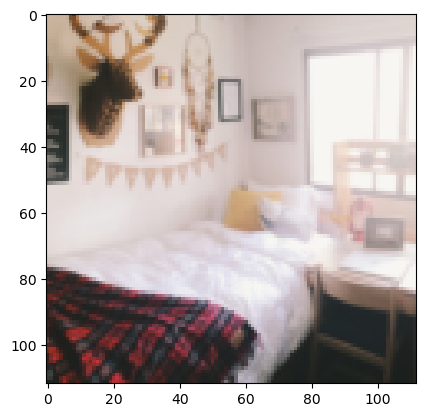

In [19]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0)) # train_dataset 데이터 확인 -> permute: torch의 경우 BRG형태이기에 RGB로 바꿔준다.

# Image Folder
- 이미지가 클래스별로 나눠져있는 경우 손쉽게 데이터셋을 만들 수 있다.

In [20]:
train_dataset2 = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/train', transforms)
valid_dataset2 = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/val', transforms)

# DataLoader
- 모델에 데이터를 입력하기 위해 필요하다.

In [21]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Model
### AlexNet

In [24]:
model = models.alexnet(pretrained = True)
model

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.classifier.parameters():
    parameter.requires_grad = True

In [26]:
model.classifier[6] = torch.nn.Linear(4096, 2) # class가 2개이므로 맞춰준다.

# Train, Eval

In [27]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_accuracy = 0
    train_loss = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_accuracy_list = []
    train_loss_list = []
    valid_accuracy_list = []
    valid_loss_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)

    return model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [30]:
model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.009528034755627838, Train Accuracy: 0.9947916666666666, Valid Loss: 0.7770447060465813, Valid Accuracy: 0.85


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.06536342809340567, Train Accuracy: 0.9739583333333334, Valid Loss: 0.8884950426527212, Valid Accuracy: 0.9


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.06244326218385732, Train Accuracy: 0.984375, Valid Loss: 0.8928734212331619, Valid Accuracy: 0.9


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.7431098417018992, Train Accuracy: 0.9166666666666666, Valid Loss: 1.1021316647188542, Valid Accuracy: 0.95


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.031656994238498215, Train Accuracy: 0.9791666666666666, Valid Loss: 0.8710182599315885, Valid Accuracy: 0.95


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.027415364560420485, Train Accuracy: 0.9895833333333334, Valid Loss: 1.1356279999017707, Valid Accuracy: 0.95


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.13886528050710467, Train Accuracy: 0.9791666666666666, Valid Loss: 1.1566219329833984, Valid Accuracy: 0.95


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.19678854642386398, Train Accuracy: 0.96875, Valid Loss: 0.9217745736241341, Valid Accuracy: 0.75


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.21499491059451734, Train Accuracy: 0.9583333333333334, Valid Loss: 1.1329316347834322, Valid Accuracy: 0.9


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.09820251391779304, Train Accuracy: 0.984375, Valid Loss: 1.0274483412504196, Valid Accuracy: 0.85


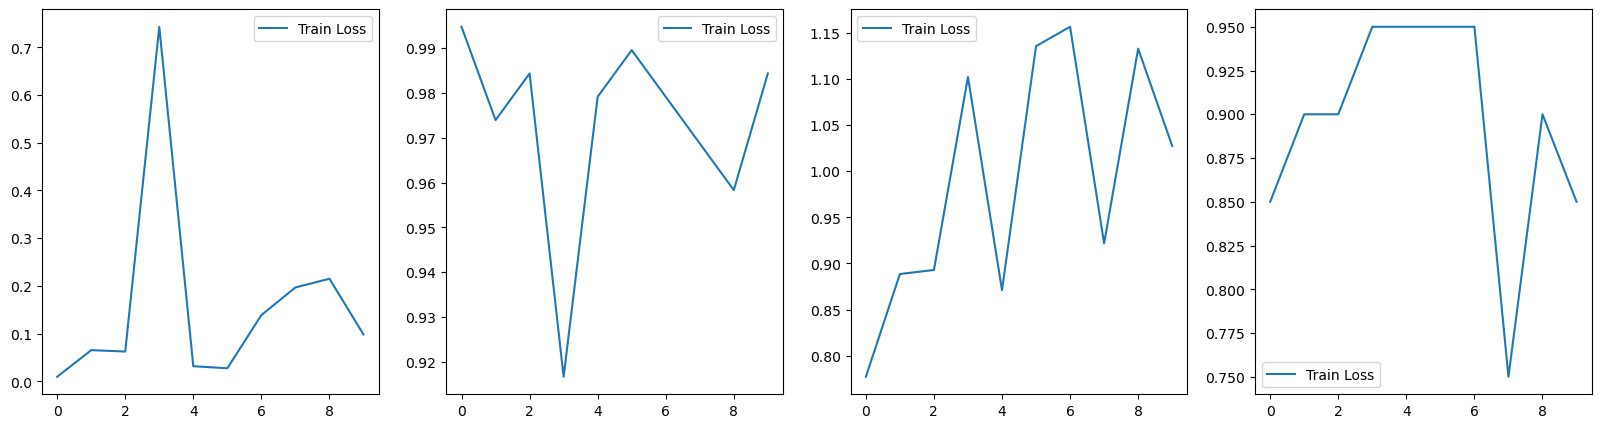

In [31]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_accuracy_list, label='Train Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(valid_loss_list, label='Train Loss')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(valid_accuracy_list, label='Train Loss')
plt.legend()

# Test

In [32]:
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/1/data/test', ['clean', 'messy'], transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [33]:
model.eval()

total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)
        total_preds.extend(predicted)

  0%|          | 0/2 [00:00<?, ?it/s]

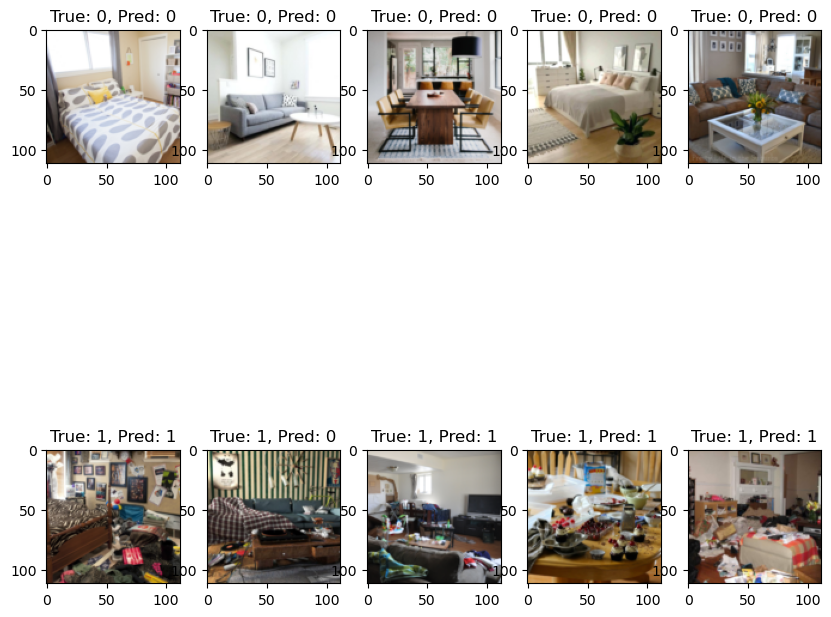

In [34]:
plt.figure(figsize=(10, 10))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {test_dataset[i][1]}, Pred: {total_preds[i].cpu().item()}')